In [ ]:
#from pyspark.sql import functions as F
# import polars as pl
# from pyspark.sql import SparkSession

import sklearn
import datetime
import numpy as np
import pandas as pd
import holidays
import xgboost as xgb
import matplotlib.pyplot as plt
import statsmodels.api as sm
import matplotlib.dates as mdates
import statsmodels.api as sm
import random
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error, mean_absolute_error
# import from sklearn metrics RMSE and MAPE
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
import warnings
import requests
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import train_test_split
from google.cloud.bigquery import Client
from google.cloud import bigquery
from datetime import timedelta
from pandas.tseries.offsets import DateOffset

warnings.filterwarnings('ignore')
client = Client(project='')

In [ ]:
def get_data(sql_file, var):  
    if var == True:
        dados = client.query(sql_file)
        result = dados.result()
        df = result.to_dataframe()
        return df
    else:
        with open(sql_file, 'r') as f:
            sql = f.read()
        dados = client.query(sql)
        result = dados.result()
        df = result.to_dataframe()
        return df


### Engenharia de Atributos

In [ ]:
def lista_holidays(df):
    df['data'] = pd.to_datetime(df.order_date)
    
    min_year = df.order_date.min().year
    max_year = df.order_date.max().year
    
    years_list = pd.period_range(min_year, max_year, freq = 'Y')
    
    list_of_holidays = []
    
    for year in years_list:
        list_of_holidays.append(holidays.BR(years = int(str(year))).keys())
        
    holiday_list = [item for sublist in list_of_holidays for item in sublist]
    
    return holiday_list

In [ ]:
def cria_atributos_date_time(df):
    df['data'] = pd.to_datetime(df.order_date)
    df['month'] = df.order_date.dt.month
    df['day_of_month'] = df.order_date.dt.day
    df['day_of_year'] = df.order_date.dt.dayofyear
    df['week_of_year'] = df.order_date.dt.isocalendar().week
    df['day_of_week'] = df.order_date.dt.weekday + 1
    df['year'] = df.order_date.dt.year 
    df['is_weekend'] = df.order_date.dt.weekday // 5
    df['start_of_month'] = df.order_date.dt.is_month_start.astype(int)
    df['end_of_month'] = df.order_date.dt.is_month_end.astype(int)
    df['is_holiday'] = np.where(df.order_date.isin(lista_holidays(df)), 1, 0)
    
    return df

In [ ]:
def easter_date(year):
    a = year % 19
    b = year // 100
    c = year % 100
    d = b // 4
    e = b % 4
    f = (b + 8) // 25
    g = (b - f + 1) // 3
    h = (19 * a + b - d - g + 15) % 30
    i = c // 4
    k = c % 4
    l = (32 + 2 * e + 2 * i - h - k) % 7
    m = (a + 11 * h + 22 * l) // 451
    month = (h + l - 7 * m + 114) // 31
    day = ((h + l - 7 * m + 114) % 31) + 1
    return pd.Timestamp(f"{year}-{month}-{day}")

def add_event_dummies(df, date_col='order_date'):
    # Ensure the date column is in datetime format
    df[date_col] = pd.to_datetime(df[date_col])
    
    # Get unique years in the DataFrame
    unique_years = df[date_col].dt.year.unique()
    
    # Initialize dummy columns as False
    event_columns = ['is_christmas', 'is_pre_christmas', 'is_childrens_day', 'is_pre_childrens_day', 'is_black_friday', 'is_pre_black_friday', 'is_carnival', 'is_pre_carnival', 'is_easter', 'is_pre_easter']
    for col in event_columns:
        df[col] = False
    
    for year in unique_years:
        # Christmas and Pre-Christmas
        christmas_date = pd.Timestamp(f"{year}-12-25").date()
        df.loc[df[date_col].dt.date == christmas_date, 'is_christmas'] = True
        df.loc[df[date_col].dt.date.isin(pd.date_range(christmas_date - timedelta(days=5), christmas_date - timedelta(days=1)).date), 'is_pre_christmas'] = True
        
        # Children's Day and Pre-Children's Day
        childrens_day_date = pd.Timestamp(f"{year}-10-12").date()
        df.loc[df[date_col].dt.date == childrens_day_date, 'is_childrens_day'] = True
        df.loc[df[date_col].dt.date.isin(pd.date_range(childrens_day_date - timedelta(days=5), childrens_day_date - timedelta(days=1)).date), 'is_pre_childrens_day'] = True
        
        # Black Friday and Pre-Black Friday
        black_friday_date = pd.date_range(f"{year}-11-01", f"{year}-11-30", freq='W-FRI')[3].date()
        df.loc[df[date_col].dt.date == black_friday_date, 'is_black_friday'] = True
        df.loc[df[date_col].dt.date.isin(pd.date_range(black_friday_date - timedelta(days=5), black_friday_date - timedelta(days=1)).date), 'is_pre_black_friday'] = True
        
        # Easter and Pre-Easter
        easter_date_year = easter_date(year).date()
        df.loc[df[date_col].dt.date == easter_date_year, 'is_easter'] = True
        df.loc[df[date_col].dt.date.isin(pd.date_range(easter_date_year - timedelta(days=5), easter_date_year - timedelta(days=1)).date), 'is_pre_easter'] = True

        # Carnival and Pre-Carnival (47 days before Easter)
        carnival_date = easter_date_year - timedelta(days=47)
        df.loc[df[date_col].dt.date == carnival_date, 'is_carnival'] = True
        df.loc[df[date_col].dt.date.isin(pd.date_range(carnival_date - timedelta(days=5), carnival_date - timedelta(days=1)).date), 'is_pre_carnival'] = True
    
    return df

In [ ]:
def add_custom_event_weights(df):
    # Initialize 'custom_event_weight' column with zeros
    df['custom_event_weight'] = 0.0
    
    # Define custom weights for each event and pre-event
    custom_weights = {
        'is_black_friday': 3,
        'is_pre_black_friday': 2,
        'is_easter': 2,
        'is_pre_easter': 1,
        'is_christmas': 1,
        'is_pre_christmas': 0.5,
        'is_childrens_day': 1,
        'is_pre_childrens_day': 0.5,
        'is_carnival': 1,
        'is_pre_carnival': 0.5
    }
    
    # Apply custom weights based on boolean flags
    for event, weight in custom_weights.items():
        df['custom_event_weight'] += df[event] * weight
    
    return df


In [ ]:
def calculate_custom_weights(df, sales_col='gross_sales'):
    event_columns = ['is_christmas', 'is_pre_christmas', 'is_childrens_day', 'is_pre_childrens_day', 'is_black_friday', 'is_pre_black_friday', 'is_carnival', 'is_pre_carnival', 'is_easter', 'is_pre_easter']
    avg_sales = {}
    for col in event_columns:
        avg_sales[col] = df.loc[df[col], sales_col].mean()
    
    # Normalize the average sales to get weights
    min_sales = min(avg_sales.values())
    custom_weights = {k: round(v / min_sales) for k, v in avg_sales.items()}
    
    return custom_weights

In [ ]:
def add_custom_event_weights_2(df, custom_weights):
    df['custom_event_weight'] = 0.0
    
    for event, weight in custom_weights.items():
        df['custom_event_weight'] += df[event] * weight
    
    return df

In [ ]:
def cria_atributos_lag(df, lag_list):
    for lag in lag_list:
        # df['lag' + str(lag)] = df.groupby(["line_id"]).gross_sales.shift(lag)
        df['lag' + str(lag)] = df.gross_sales.shift(lag)
    return df

In [ ]:
def cria_atributo_rolling_mean_360(df, windows_list):
    for window in windows_list:
        # df['vendas_rolling_mean_180_' + str(window)] = df.groupby(["line_id"]).gross_sales.rolling(window).mean().shift(365).values
        df['vendas_rolling_mean_180_' + str(window)] = df.gross_sales.rolling(window).mean().shift(365).values
    return df

In [ ]:
def cria_atributo_rolling_mean_720(df, windows_list):
    for window in windows_list:
        # df['vendas_rolling_mean_720_' + str(window)] = df.groupby("line_id"]).gross_sales.rolling(window).mean().shift(730).values
        df['vendas_rolling_mean_720_' + str(window)] = df.gross_sales.rolling(window).mean().shift(730).values
    return df

In [ ]:
def cria_atributo_rolling_mean_1095(df, windows_list):
    for window in windows_list:
        # df['vendas_rolling_mean_360_' + str(window)] = df.groupby(["line_id"]).gross_sales.rolling(window).mean().shift(1095).values
        df['vendas_rolling_mean_360_' + str(window)] = df.gross_sales.rolling(window).mean().shift(1095).values
    return df

In [ ]:
def handle_infinite_values(df):
    return df.replace([np.inf, -np.inf], np.nan)

In [ ]:
def cria_atributo_percent_growth_window_365(df, windows_list):
    for window in windows_list:
        col_name = 'percent_growth_window_' + str(window)
        df[col_name] = df['gross_sales'].pct_change(periods=window) * 100
        df[col_name] = df[col_name].shift(365)
    df = handle_infinite_values(df)
    return df

In [ ]:
def cria_atributo_absolute_change_window_365(df, windows_list):
    df['gross_sales'] = df['gross_sales'].astype(int)
    for window in windows_list:
        col_name = 'absolute_change_window_' + str(window)
        # df[col_name] = df.groupby("line_id"])['gross_sales'].apply(lambda x: x.diff(periods=window)).shift(365).values
        df[col_name] = df['gross_sales'].diff(periods=window).shift(365).values
    df = handle_infinite_values(df)
    return df

In [ ]:
def cria_atributo_std_dev_window_365(df, windows_list):
    df['gross_sales'] = df['gross_sales'].astype(int)
    for window in windows_list:
        col_name = 'std_dev_window_' + str(window)
        # df[col_name] = df.groupby(["line_id"])['gross_sales'].rolling(window=window).std().reset_index(0, drop=True).shift(365).values
        df[col_name] = df['gross_sales'].rolling(window=window).std().reset_index(0, drop=True).shift(365).values
    return df

In [ ]:
def cria_atributos_ewm(df, alphas, lags):
    for alpha in alphas:
        for lag in lags:
            df['sales_ewm_alpha_' + str(alpha).replace(".","") + 
              # "_lag_" + str(lag)] = df.groupby(["department_id","line_id"]).gross_sales.transform(
              "_lag_" + str(lag)] = df.gross_sales.transform(
            lambda x: x.shift(lag).ewm(alpha = alpha).mean())
    return df


In [ ]:
def add_in_outlier_dummy(df, col_name='gross_sales'):
    Q1 = df[col_name].quantile(0.25)
    Q3 = df[col_name].quantile(0.75)
    IQR = Q3 - Q1
    
    lower_bound = Q1 - 3 * IQR
    upper_bound = Q3 + 3 * IQR
    
    df['in_outlier'] = 0
    df.loc[(df[col_name] < lower_bound) | (df[col_name] > upper_bound), 'in_outlier'] = 1
    
    return df


In [ ]:
def add_outlier_weights(df, col_name='gross_sales'):
    Q1 = df[col_name].quantile(0.25)
    Q3 = df[col_name].quantile(0.75)
    IQR = Q3 - Q1

    lower_bound = Q1 - 3 * IQR
    upper_bound = Q3 + 3 * IQR

    # Inicializar coluna de peso de outliers com zeros
    df['outlier_weight'] = 0.0

    # Identificar os outliers
    outliers = (df[col_name] < lower_bound) | (df[col_name] > upper_bound)

    # Calcular o peso para os outliers
    df.loc[outliers, 'outlier_weight'] = np.abs(df.loc[outliers, col_name] - np.where(df.loc[outliers, col_name] < lower_bound, lower_bound, upper_bound)) / IQR

    return df

In [ ]:
def interpolate_outliers_with_mean(df, col_name='gross_sales'):
    # Calcular Q1, Q3 e IQR
    Q1 = df[col_name].quantile(0.25)
    Q3 = df[col_name].quantile(0.75)
    P10 = df[col_name].quantile(0.10)
    P90 = df[col_name].quantile(0.90)
    IQR = P90 - P10
    
    # Limites para outliers
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    # Identificar os outliers
    outliers = (df[col_name] < lower_bound) | (df[col_name] > upper_bound)
    
    # Calcular a média dos valores que não são outliers
    mean_without_outliers = df.loc[~outliers, col_name].mean()
    
    # Substituir os outliers pela média
    df.loc[outliers, col_name] = mean_without_outliers

### Dados para treino

In [ ]:
department_id = 1
line_id = 'L01010106'

In [77]:
query_serie = fr"""
SELECT
     order_date
     , SUM(gross_sales) gross_sales
  FROM `table`
 WHERE TRUE
   AND department_id = {department_id}
   -- AND line_id    = '{line_id}'
   AND order_date < '2024-01-01'
 GROUP BY 1
"""

venda_companhia = get_data(query_serie, True)
venda_companhia.to_csv("df_venda_companhia.csv", sep=';', decimal=',', encoding='utf-8-sig', index=False)

<Axes: xlabel='order_date'>

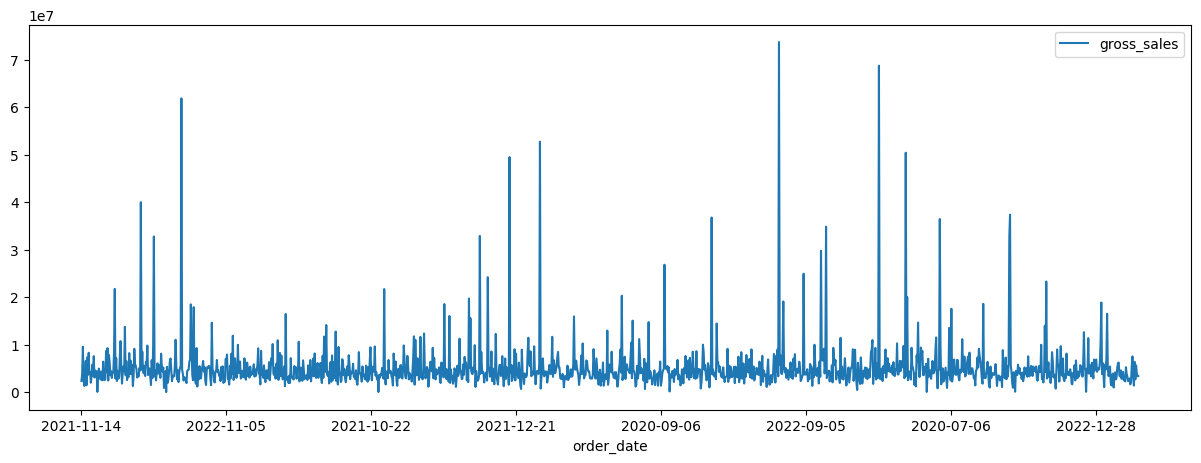

In [78]:
venda_companhia.plot(x='order_date', y='gross_sales', figsize=(15, 5))

<Axes: xlabel='order_date'>

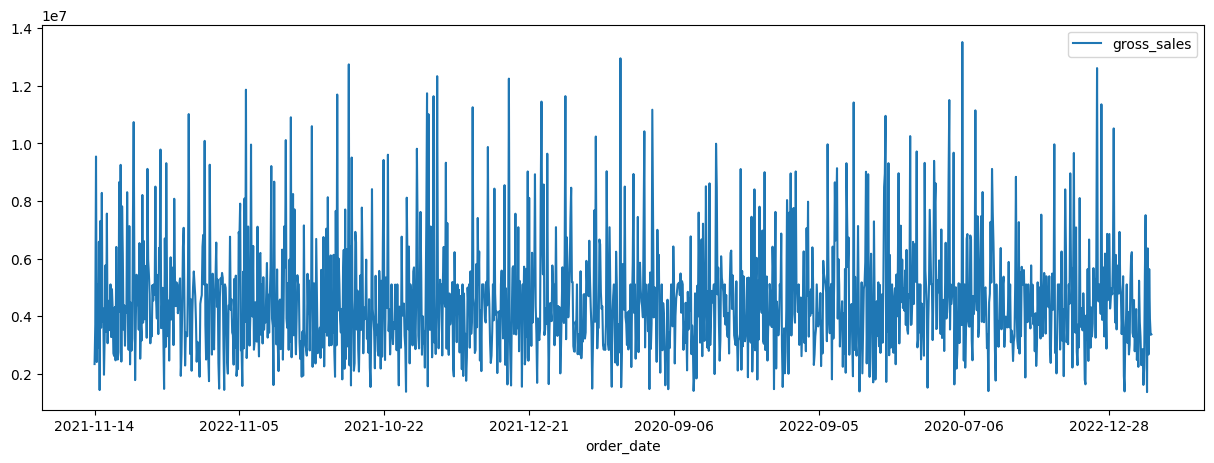

In [79]:
q_low = venda_companhia['gross_sales'].quantile(0.03)
q_high = venda_companhia['gross_sales'].quantile(0.97)

median = venda_companhia['gross_sales'].mean()

venda_companhia['gross_sales'] = np.where(venda_companhia['gross_sales'] < q_low, median, venda_companhia['gross_sales'])
venda_companhia['gross_sales'] = np.where(venda_companhia['gross_sales'] > q_high, median, venda_companhia['gross_sales'])

venda_companhia.plot(x='order_date', y='gross_sales', figsize=(15, 5))

### Dados para validacao do Overfitting

In [80]:
query_serie = fr"""
SELECT
     order_date
     , SUM(gross_sales) gross_sales
  FROM `table`
 WHERE TRUE
   AND department_id = {department_id}
   -- AND order_date >= '2024-01-01'
 GROUP BY 1
"""


dados_hoje = get_data(query_serie, True)
dados_hoje.to_csv("dados_hoje.csv", sep=';', decimal=',', encoding='utf-8-sig', index=False)

In [81]:
dados_hoje['data'] = dados_hoje['order_date']
dados_hoje.drop('order_date', axis=1, inplace=True)
# convert data to datetime
dados_hoje['data'] = pd.to_datetime(dados_hoje['data'])
dados_hoje.set_index('data', inplace=True)
dados_hoje['gross_sales'] = np.log1p(dados_hoje['gross_sales'].values)


q_low = dados_hoje['gross_sales'].quantile(0.03)
q_high = dados_hoje['gross_sales'].quantile(0.97)

median = dados_hoje['gross_sales'].mean()

dados_hoje['gross_sales'] = np.where(dados_hoje['gross_sales'] < q_low, median, dados_hoje['gross_sales'])
dados_hoje['gross_sales'] = np.where(dados_hoje['gross_sales'] > q_high, median, dados_hoje['gross_sales'])



Y_prev = dados_hoje['gross_sales']
Y_prev = Y_prev.sort_index(ascending=True)
Y_prev

data
2020-01-01    15.237138
2020-01-02    15.010479
2020-01-03    15.191503
2020-01-04    15.162179
2020-01-05    14.459943
                ...    
2024-02-28    15.542323
2024-02-29    16.081212
2024-03-01    16.072104
2024-03-02    16.107715
2024-03-03    15.176895
Name: gross_sales, Length: 1523, dtype: float64

In [113]:
data = pd.date_range(start='2024-03-04', end='2024-12-31')
data = pd.DataFrame(data, columns=['data'])
data['order_date'] = data['data']
data = data.drop('data', axis=1)


cross_join = data.copy()
cross_join['gross_sales'] = 0
venda_companhia['order_date'] = pd.to_datetime(venda_companhia['order_date'])
df_xboost_previsor = pd.concat([venda_companhia, cross_join], ignore_index=True)
df_xboost_previsor

,order_date,gross_sales
0,2021-11-14,2.344839e+06
1,2022-09-27,3.717646e+06
2,2023-11-16,9.545499e+06
3,2020-12-13,2.415412e+06
4,2020-05-10,5.109122e+06
...,...,...
1758,2024-12-27,0.000000e+00
1759,2024-12-28,0.000000e+00
1760,2024-12-29,0.000000e+00
1761,2024-12-30,0.000000e+00


### Automatizacao do modelo

In [83]:
lag_list = [360,361,362,362,364,365,366,367,390,405,420,435,450,480,495,510,525,540,555,570,585,600,615,630,645,660,675,690,720,750,760,790,810,840,870,900,930,960,990]
windows_list = [1,2,3,4,5,6,7,8,9,10,12,14,21,30,35,45,60,91,98,105,112,119,126,150,186,200,210,250,270,300,330,365,720]
lags = [360,361,362,362,364,365,366,367,390,405,420,435,450,480,495,510,525,540,555,570,585,600,615,630,645,660,675,690,720]
alpha_list = [0.95, 0.9, 0.85, 0.8, 0.75, 0.7, 0.65, 0.6]

In [84]:
def random_sublist(input_list):
    return [item for item in input_list if random.choice([True, False])]

def preprocess_data(df_treino, df_validacao, date_col='order_date', sales_col='gross_sales', lag_list=None, windows_list=None, alpha_list=None, lags=None, i=0, random_state=False):
    feature_flags = {
        'cria_atributos_lag': random.choice([True, False]),
        'cria_atributo_rolling_mean_360': random.choice([True, False]),
        'cria_atributo_rolling_mean_720': random.choice([True, False]),
        'cria_atributo_rolling_mean_1095': random.choice([True, False]),
        'cria_atributo_absolute_change_window_365': random.choice([True, False]),
        'cria_atributo_percent_growth_window_365': random.choice([True, False]),
        'cria_atributo_std_dev_window_365': random.choice([True, False]),
        'cria_atributos_ewm': random.choice([True, False])
    }

    subsample_lag_list = random_sublist(lag_list)
    subsample_windows_list = random_sublist(windows_list)
    subsample_alpha_list = random_sublist(alpha_list)
    subsample_lags = random_sublist(lags)
    
    def treinar(df):
        df = cria_atributos_date_time(df)
        if random_state:
            if feature_flags['cria_atributos_lag']:
                df = cria_atributos_lag(df, subsample_lag_list)
            if feature_flags['cria_atributo_rolling_mean_360']:
                df = cria_atributo_rolling_mean_360(df, subsample_windows_list)
            if feature_flags['cria_atributo_rolling_mean_720']:
                df = cria_atributo_rolling_mean_720(df, subsample_windows_list)
            if feature_flags['cria_atributo_rolling_mean_1095']:
                df = cria_atributo_rolling_mean_1095(df, subsample_windows_list)
            if feature_flags['cria_atributo_absolute_change_window_365']:
                df = cria_atributo_absolute_change_window_365(df, subsample_windows_list)
            if feature_flags['cria_atributo_percent_growth_window_365']:
                df = cria_atributo_percent_growth_window_365(df, subsample_windows_list)
            if feature_flags['cria_atributo_std_dev_window_365']:
                df = cria_atributo_std_dev_window_365(df, subsample_windows_list)
            if feature_flags['cria_atributos_ewm']:
                df = cria_atributos_ewm(df, subsample_alpha_list, subsample_lags)
        else:
            df = cria_atributos_lag(df, lag_list)
            df = cria_atributo_rolling_mean_360(df, windows_list)
            df = cria_atributo_rolling_mean_720(df, windows_list)
            df = cria_atributo_rolling_mean_1095(df, windows_list)
            df = cria_atributo_absolute_change_window_365(df, windows_list)
            df = cria_atributo_percent_growth_window_365(df, windows_list)
            df = cria_atributo_std_dev_window_365(df, windows_list)
            df = cria_atributos_ewm(df, alpha_list, lags)
        df = pd.get_dummies(df, columns=['day_of_week', 'month'])
        df = df.set_index('data')

        features_aplicadas = {
                'Modelo': i,
                'cria_atributos_lag': feature_flags['cria_atributos_lag'],
                'cria_atributo_rolling_mean_360': feature_flags['cria_atributo_rolling_mean_360'],
                'cria_atributo_rolling_mean_720': feature_flags['cria_atributo_rolling_mean_720'],
                'cria_atributo_rolling_mean_1095': feature_flags['cria_atributo_rolling_mean_1095'],
                'cria_atributo_absolute_change_window_365': feature_flags['cria_atributo_absolute_change_window_365'],
                'cria_atributo_percent_growth_window_365': feature_flags['cria_atributo_percent_growth_window_365'],
                'cria_atributo_std_dev_window_365': feature_flags['cria_atributo_std_dev_window_365'],
                'cria_atributos_ewm': feature_flags['cria_atributos_ewm'],
                'listas': {
                    'lag_list': subsample_lag_list,
                    'windows_list': subsample_windows_list,
                    'alpha_list': subsample_alpha_list,
                    'lags': subsample_lags
                }
            }
        return df, features_aplicadas
    df_treino, features_aplicadas = treinar(df_treino)
    df_validacao, _ = treinar(df_validacao)
    
    return df_treino, df_validacao, features_aplicadas

In [85]:
def transforma_modelos(df_treino, df_validacao, date_col='order_date', sales_col='gross_sales', lag_list=None, windows_list=None, alpha_list=None, lags=None, i=0, random_state=False):
    # Trabalhando com df_treino
    df_treino = df_treino.copy()
    df_treino[date_col] = pd.to_datetime(df_treino[date_col])
    df_treino = add_event_dummies(df_treino, date_col=date_col)
    custom_weights = calculate_custom_weights(df_treino, sales_col=sales_col)
    # df_treino = add_custom_event_weights_2(df_treino, custom_weights)

    df_validacao[date_col] = pd.to_datetime(df_validacao[date_col])
    df_validacao = add_event_dummies(df_validacao, date_col=date_col)
    # df_validacao = add_custom_event_weights_2(df_validacao, custom_weights)
    
    # Decide qual conjunto de colunas manter
    if random_state:
        choice = random.choice(['custom_event_weight', 'event_columns', 'none'])
        
        event_columns = ['is_christmas', 'is_pre_christmas', 'is_childrens_day', 'is_pre_childrens_day', 'is_black_friday', 'is_pre_black_friday', 'is_carnival', 'is_pre_carnival', 'is_easter', 'is_pre_easter']
        if choice == 'custom_event_weight':
            df_treino.drop(columns=event_columns, inplace=True)
            df_validacao.drop(columns=event_columns, inplace=True)
        elif choice == 'event_columns':
            df_treino.drop(columns=['custom_event_weight'], inplace=True)
            df_validacao.drop(columns=['custom_event_weight'], inplace=True)
        else:
            df_treino.drop(columns=event_columns + ['custom_event_weight'], inplace=True)
            df_validacao.drop(columns=event_columns + ['custom_event_weight'], inplace=True)

    df_treino, df_validacao, features_aplicadas = preprocess_data(df_treino, df_validacao, date_col=date_col, sales_col=sales_col, lag_list=lag_list, windows_list=windows_list, alpha_list=alpha_list, lags=lags, i=i)
    
    df_treino['gross_sales'] = np.log1p(df_treino["gross_sales"].values)
    df_treino['week_of_year'] = df_treino['week_of_year'].astype('int32')
    df_validacao['gross_sales'] = np.log1p(df_validacao["gross_sales"].values)
    
    if random_state:
        features_aplicadas['choice'] = choice
    
    return df_treino, df_validacao, features_aplicadas
    

In [114]:
df_xboost, df_xboost_previsor, _ = transforma_modelos(venda_companhia, df_xboost_previsor, date_col='order_date', sales_col='gross_sales', lag_list=lag_list, windows_list=windows_list, alpha_list=alpha_list, lags=lags, i=0, random_state=False)

cols = [col for col in df_xboost.columns if col not in ['order_date', 'id', "gross_sales", "year"]]
X = df_xboost[cols]
Y = df_xboost['gross_sales']
X_treino, X_teste, y_treino, y_teste = train_test_split(X, Y, test_size = 0.2, random_state = 1)
X_treino, X_val, y_treino, y_val = train_test_split(X_treino, y_treino, test_size = 0.25, random_state = 1)

In [115]:
# treining model using XGBoost and cross validation
max_depth = 15
learning_rate = 0.2
min_child_weight = 3
alpha = 0.5
lambda_ = 0.5
n_estimators = 800

# Crie o modelo XGBoost com os hiperparâmetros definidos
modelo_xgb = xgb.XGBRegressor(
    max_depth=max_depth,
    learning_rate=learning_rate,
    n_estimators=n_estimators,
    min_child_weight=min_child_weight,
    alpha=alpha,
    lambda_=lambda_,
)

# Treine o modelo
modelo_xgb.fit(
    X_treino,
    y_treino,
    eval_set=[(X_val, y_val)],
    verbose=True,
    eval_metric='rmse',
    early_stopping_rounds=20
)

[0]	validation_0-rmse:0.38974
[1]	validation_0-rmse:0.36872
[2]	validation_0-rmse:0.35950
[3]	validation_0-rmse:0.35437
[4]	validation_0-rmse:0.35132
[5]	validation_0-rmse:0.34877
[6]	validation_0-rmse:0.34956
[7]	validation_0-rmse:0.35101
[8]	validation_0-rmse:0.35051
[9]	validation_0-rmse:0.35157
[10]	validation_0-rmse:0.35203
[11]	validation_0-rmse:0.35267
[12]	validation_0-rmse:0.35302
[13]	validation_0-rmse:0.35393
[14]	validation_0-rmse:0.35504
[15]	validation_0-rmse:0.35561
[16]	validation_0-rmse:0.35589
[17]	validation_0-rmse:0.35635
[18]	validation_0-rmse:0.35730
[19]	validation_0-rmse:0.35822
[20]	validation_0-rmse:0.35901
[21]	validation_0-rmse:0.35938
[22]	validation_0-rmse:0.35947
[23]	validation_0-rmse:0.36046
[24]	validation_0-rmse:0.36042


XGBRegressor(alpha=0.5, base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, lambda_=0.5, learning_rate=0.2,
             max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=15, max_leaves=None,
             min_child_weight=3, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=800, n_jobs=None, ...)

In [117]:
previsoes_treino = modelo_xgb.predict(X_teste)
previsoes_val = modelo_xgb.predict(df_xboost_previsor[cols])

# add date to previsoes_ult_trim_xgb
df_previsto = df_xboost_previsor.copy()
df_previsto['previsao'] = np.expm1(previsoes_val)
df_previsto = np.log1p(df_previsto['previsao'])

# filter df_previsto with index date from serie Y_prev
df_previsto = df_previsto[df_previsto.index.isin(Y_prev.index)]
df_previsto

data
2021-11-14    14.974296
2022-09-27    15.076588
2023-11-16    15.634447
2020-12-13    15.040969
2020-05-10    14.900114
                ...    
2022-03-27    14.900785
2023-09-23    15.446797
2021-07-27    15.217404
2023-01-30    15.140905
2020-02-11    15.105425
Name: previsao, Length: 1460, dtype: float32

In [119]:
df_previsto[df_previsto.index.year == 2023]

data
2023-11-16    15.634447
2023-09-14    15.135821
2023-08-27    14.955473
2023-12-07    15.543439
2023-07-05    15.477012
                ...    
2023-03-12    15.199490
2023-03-11    15.641743
2023-03-04    15.372333
2023-09-23    15.446797
2023-01-30    15.140905
Name: previsao, Length: 364, dtype: float32

In [120]:
mae_treino   = mean_absolute_error(previsoes_treino, y_teste.values)
mse_treino   = mean_squared_error(previsoes_treino, y_teste.values)
rmse_treino  = mean_squared_error(previsoes_treino, y_teste.values, squared=False)
mape_treino  = mean_absolute_percentage_error(previsoes_treino, y_teste.values)

#filter df_previsto with index date after 2022
df_previsto_2023 = df_previsto[df_previsto.index.year == 2023]
Y_prev_2023 = Y_prev[Y_prev.index.year == 2023]

mae_validacao   = mean_absolute_error(df_previsto_2023,Y_prev_2023.values)
mse_validacao   = mean_squared_error(df_previsto_2023,Y_prev_2023.values)
rmse_validacao  =  mean_squared_error(df_previsto_2023,Y_prev_2023.values, squared=False)
mape_validacao  =  mean_absolute_percentage_error(df_previsto_2023,Y_prev_2023.values)

In [121]:
print(f"MAE treino: {mae_treino} |",f'MAE validação: {mae_validacao}')
print(f"MSE treino: {mse_treino} |",f'MSE validação: {mse_validacao}')
print(f"RMSE treino: {rmse_treino} |",f'RMSE validação: {rmse_validacao}')
print(f"MAPE treino: {mape_treino} |",f'MAPE validação: {mape_validacao}')

MAE treino: 0.250666830558531 | MAE validação: 0.37882583423644284
MSE treino: 0.10081106635903833 | MSE validação: 0.2232242350626207
RMSE treino: 0.3175075847267878 | RMSE validação: 0.47246612054476533
MAPE treino: 0.016427461515402506 | MAPE validação: 0.02478223107731844


Text(0.5, 1.0, 'XGBoost Prediction')

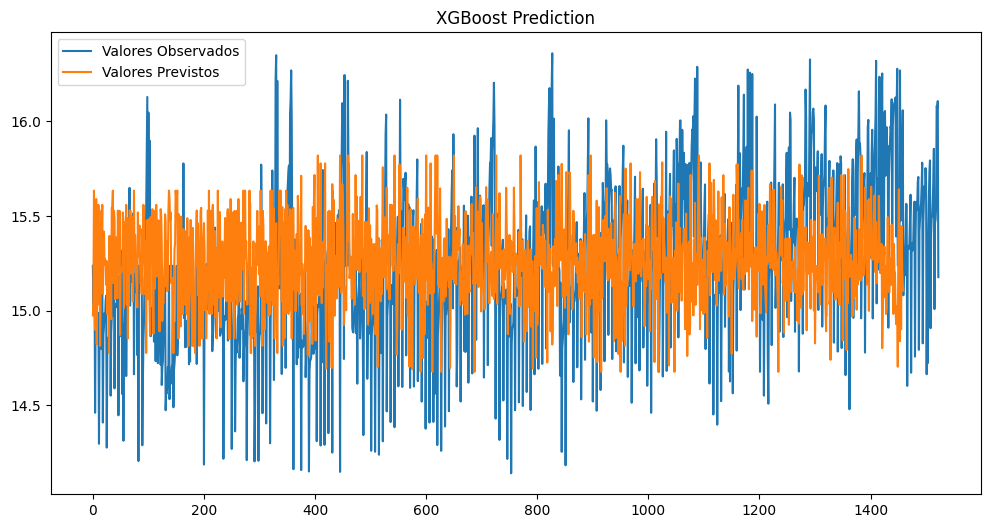

In [122]:
# Plot
fig = plt.figure(figsize = (12,6))
sales = plt.plot(Y_prev.values, label = 'Valores Observados')
forecast = plt.plot(df_previsto.values, label = 'Valores Previstos')
plt.legend(loc = 'best')
plt.title("XGBoost Prediction")

Text(0.5, 1.0, 'XGBoost Prediction')

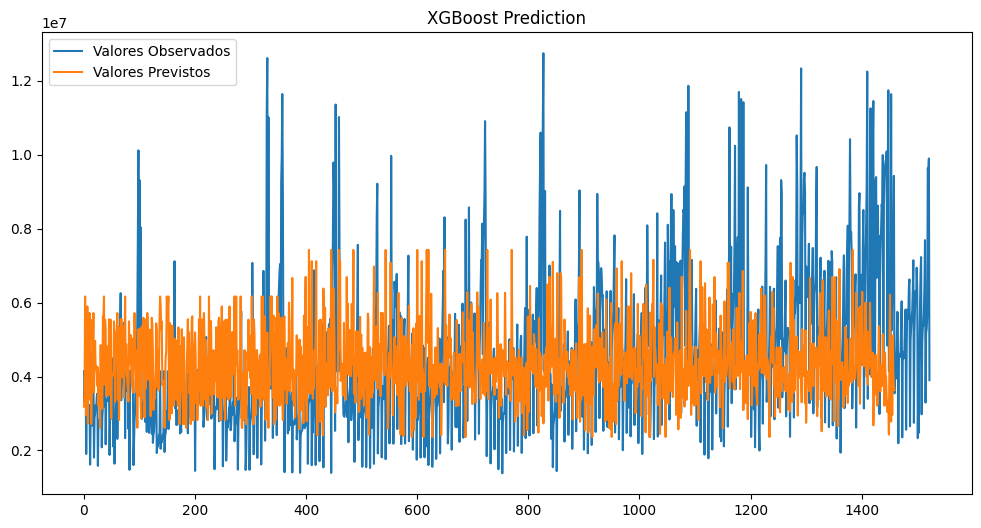

In [123]:
# Plot
fig = plt.figure(figsize = (12,6))
sales = plt.plot(np.expm1(Y_prev.values), label = 'Valores Observados')
forecast = plt.plot(np.expm1(df_previsto.values), label = 'Valores Previstos')
plt.legend(loc = 'best')
plt.title("XGBoost Prediction")

In [124]:
previsoes_futuro_original = np.expm1(previsoes_val)

df = df_xboost_previsor[cols].reset_index(inplace=False)

df_previsoes_treino = pd.DataFrame({
    'data': df['data'].iloc[:len(previsoes_val)],
    'previsao': previsoes_futuro_original
}) 

# group by data suming previsao and Y_previsor
df_previsoes_treino = df_previsoes_treino.groupby(['data']).sum().reset_index()

In [125]:
# ROUND THE NUMBER

lower_bound = np.expm1(Y_prev_2023).quantile(0.10)
upper_bound = np.expm1(Y_prev_2023).quantile(0.90)

# Filtrar os valores que estão entre os percentis 10 e 90
filtered_Y_prev_2023 = np.expm1(Y_prev_2023)[(np.expm1(Y_prev_2023) >= lower_bound) & (np.expm1(Y_prev_2023) <= upper_bound)]


venda_2023    = np.expm1(Y_prev_2023).sum()
previsao_2023 = df_previsoes_treino[df_previsoes_treino['data'] >= '2023-01-01']['previsao'].sum()


print('Venda de 2023: ', round(venda_2023,2))
print('Previsão de 2023: ', round(previsao_2023,2))
print('Erro do modelo: ', abs(round(previsao_2023/venda_2023-1,4)))


Venda de 2023:  2034221230.26
Previsão de 2023:  3023115300.0
Erro do modelo:  0.4861


### Arima com os resíduos

In [126]:
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller

In [127]:
df_previsoes_treino.reset_index(inplace=True)

In [128]:
df_previsao_grandeza = df_previsoes_treino.copy()
df_previsao_grandeza.set_index('data', inplace=True)

venda = pd.DataFrame(Y_prev, columns=['gross_sales'])
venda['gross_sales'] = np.expm1(venda['gross_sales'])

# subtrai a previsão da venda real para obter a diferença
df_diferenca = pd.DataFrame()
df_diferenca['diferenca'] = venda['gross_sales'] - df_previsao_grandeza['previsao']
# df_diferenca['diferenca'] = np.log(df_diferenca['diferenca'])
df_diferenca['diferenca'] = df_diferenca['diferenca'].fillna(df_diferenca['diferenca'].mean())
df_diferenca = df_diferenca.iloc[1:]
df_diferenca

,diferenca
data,
2020-01-02,-8.924423e+05
2020-01-03,-1.492169e+05
2020-01-04,-9.395746e+05
2020-01-05,-7.075361e+05
2020-01-06,-1.119175e+06
...,...
2024-12-27,1.623383e+05
2024-12-28,1.623383e+05
2024-12-29,1.623383e+05


In [129]:
resultado = seasonal_decompose(df_diferenca['diferenca'], model = 'additive', period = 30)

([], [])

<Figure size 640x480 with 0 Axes>

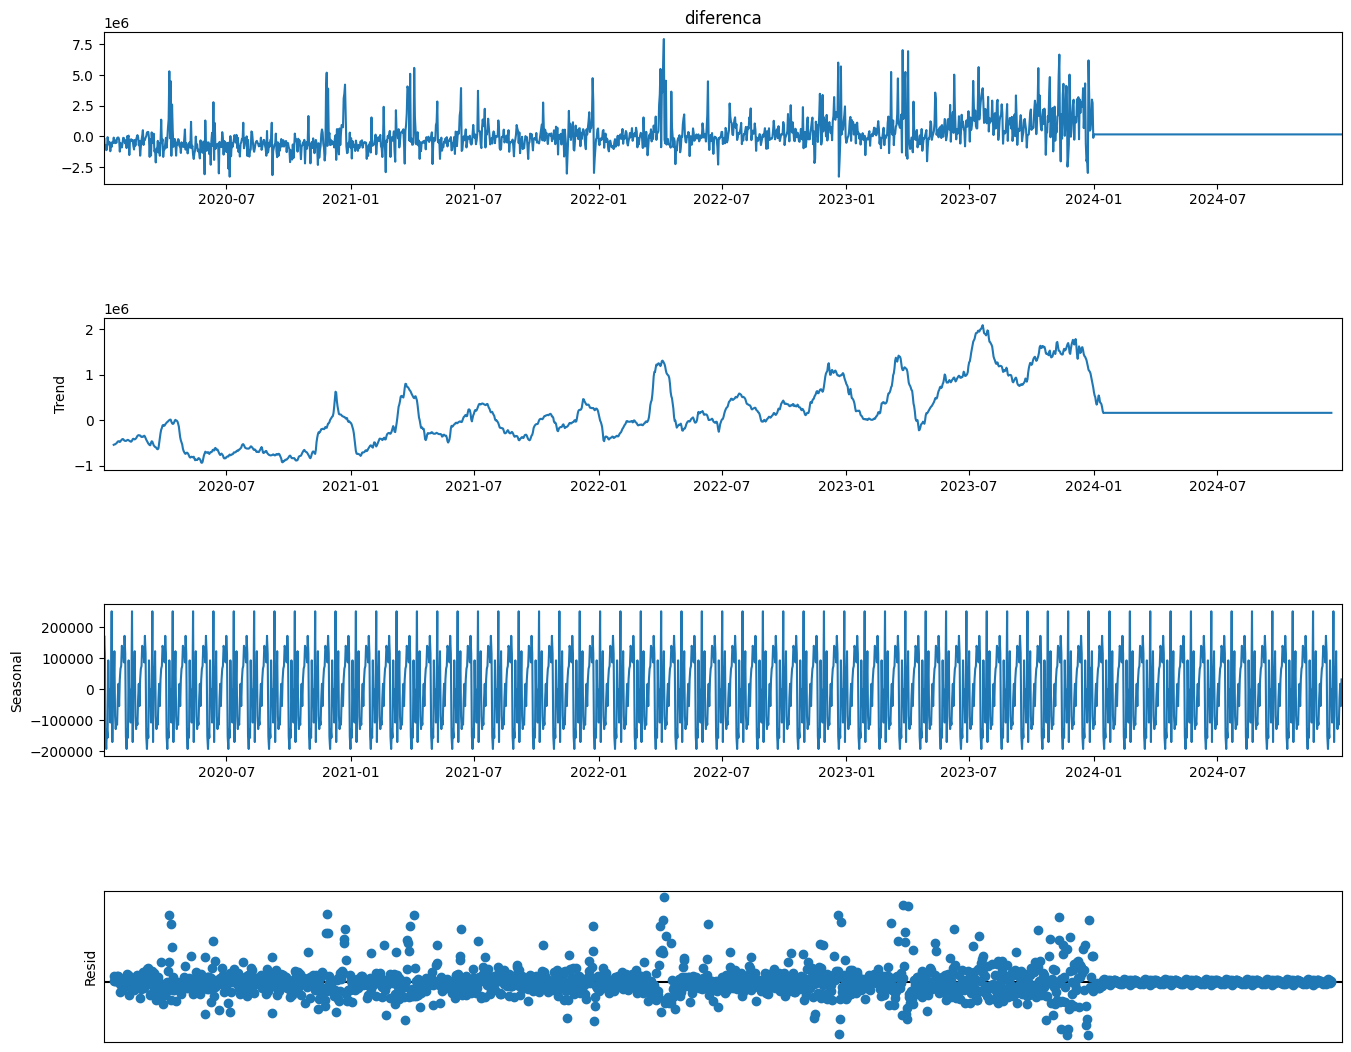

In [130]:
fig = plt.figure()  
fig = resultado.plot()  
fig.set_size_inches(15, 12)
plt.xticks([]) 
plt.yticks([]) 

In [131]:
def visualiza_estacionaridade(dados_serie):
    
    rolling_mean = dados_serie.rolling(12).mean()
    rolling_std = dados_serie.rolling(12).std()
    
    fig = plt.figure(figsize = (12,6))
    time_series = plt.plot(dados_serie, label = 'Itens Vendidos')
    mean = plt.plot(rolling_mean, color = 'yellow', label = "Média Móvel")
    std = plt.plot(rolling_std, color = 'green', label = "Desvio Padrão Móvel")
    
    plt.legend(loc = 'best')
    plt.title("Visualizando a Estacionaridade")
    plt.xticks([]) 
    plt.yticks([]) 
    plt.show()

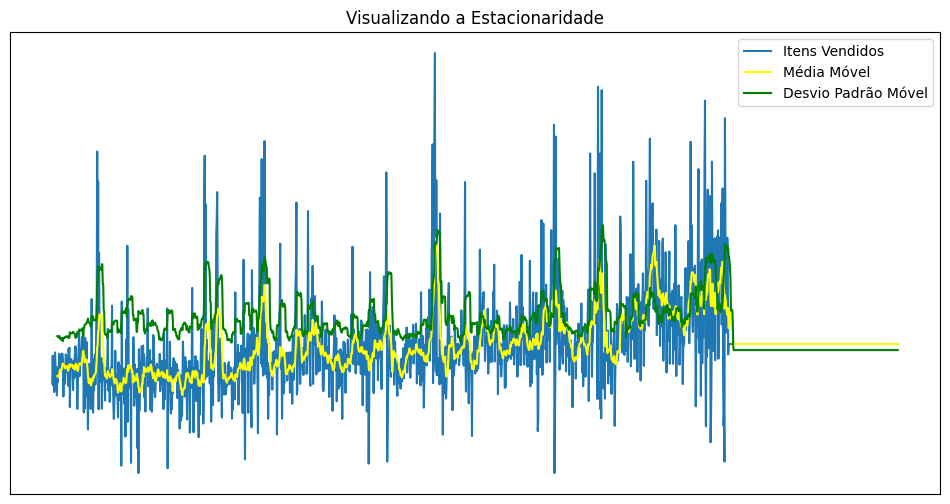

In [132]:
visualiza_estacionaridade(df_diferenca)

In [133]:
resultado_adft = adfuller(df_diferenca)
resultado_adft

(-4.628028460956683,
 0.00011464602210700623,
 24,
 1800,
 {'1%': -3.4339881389288407,
  '5%': -2.863147035877915,
  '10%': -2.567625533641975},
 54938.970275448526)

In [134]:
# Resultado
if resultado_adft[1] < 0.05:
    print('O valor-p é menor que 0.05. Podemos rejeitar a H0. A série é estacionária.')
else:
    print('O valor-p é maior que 0.05. Não podemos rejeitar a H0. A série não é estacionária.')

O valor-p é menor que 0.05. Podemos rejeitar a H0. A série é estacionária.


In [135]:
first_diff = df_diferenca.diferenca - df_diferenca.diferenca.shift(1)
first_diff = first_diff.dropna()
second_diff = first_diff - first_diff.shift(1)
second_diff = second_diff.dropna()
second_diff

data
2020-01-04   -1533583.05
2020-01-05    1022396.16
2020-01-06    -643677.57
2020-01-07     452898.66
2020-01-08     973605.61
                 ...    
2024-12-27          0.00
2024-12-28          0.00
2024-12-29          0.00
2024-12-30          0.00
2024-12-31          0.00
Name: diferenca, Length: 1823, dtype: float64

In [136]:
prim_dif = pd.DataFrame(first_diff)
resultado = seasonal_decompose(prim_dif['diferenca'], model = 'additive', period = 30)

([], [])

<Figure size 640x480 with 0 Axes>

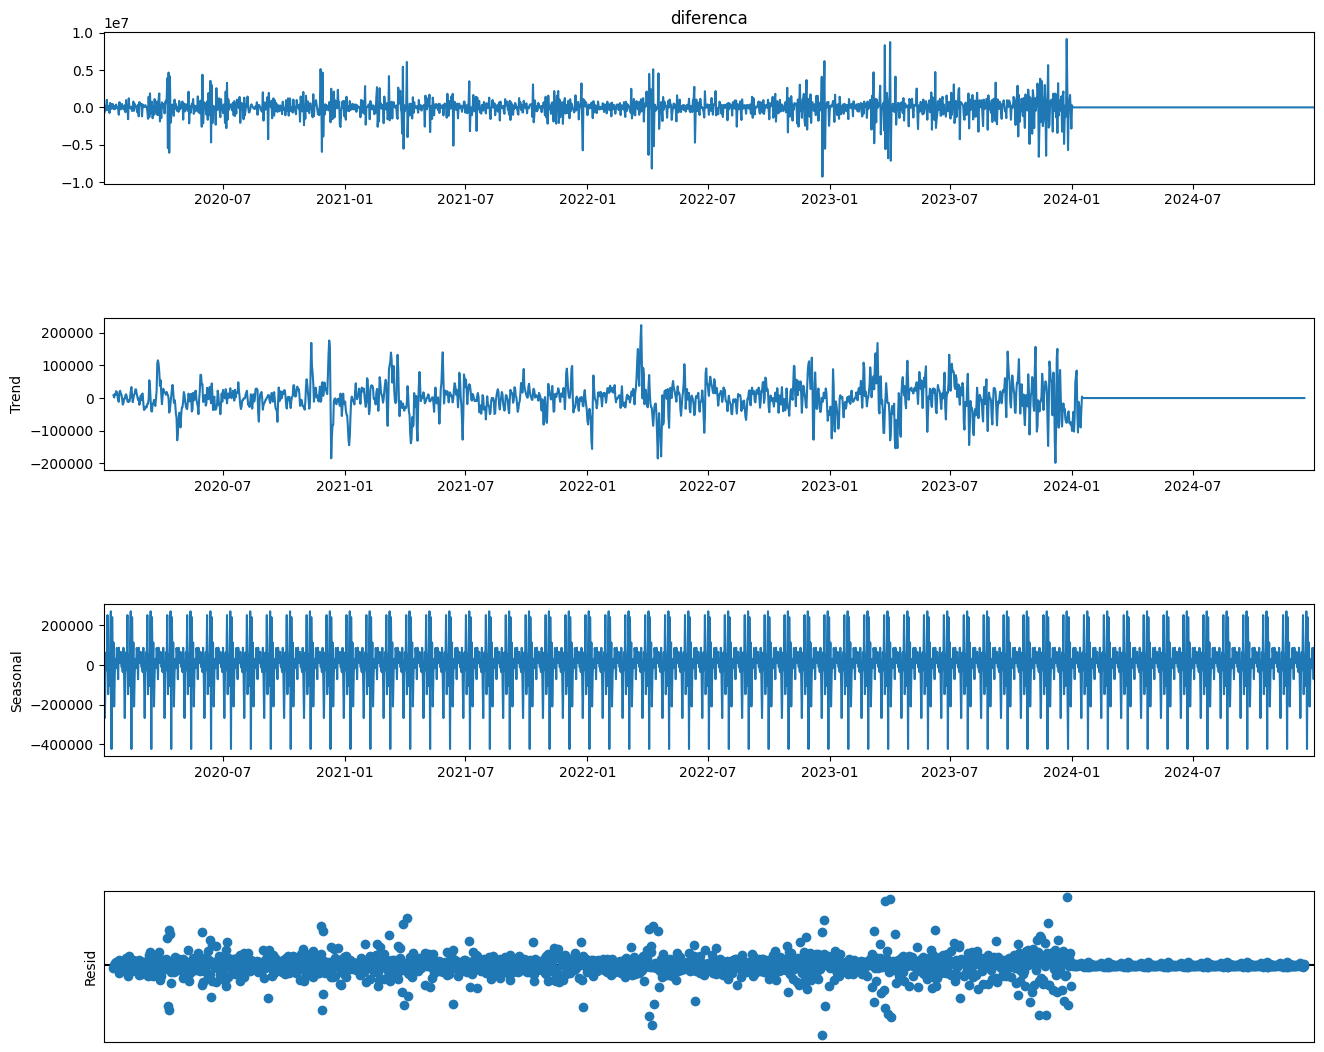

In [137]:
fig = plt.figure()  
fig = resultado.plot()  
fig.set_size_inches(15, 12)
plt.xticks([]) 
plt.yticks([]) 

In [138]:
def visualiza_estacionaridade(dados_serie):
    
    rolling_mean = dados_serie.rolling(12).mean()
    rolling_std = dados_serie.rolling(12).std()
    
    fig = plt.figure(figsize = (12,6))
    time_series = plt.plot(dados_serie, label = 'Itens Vendidos')
    mean = plt.plot(rolling_mean, color = 'yellow', label = "Média Móvel")
    std = plt.plot(rolling_std, color = 'green', label = "Desvio Padrão Móvel")
    
    plt.legend(loc = 'best')
    plt.title("Visualizando a Estacionaridade")
    plt.xticks([]) 
    plt.yticks([]) 
    plt.show()

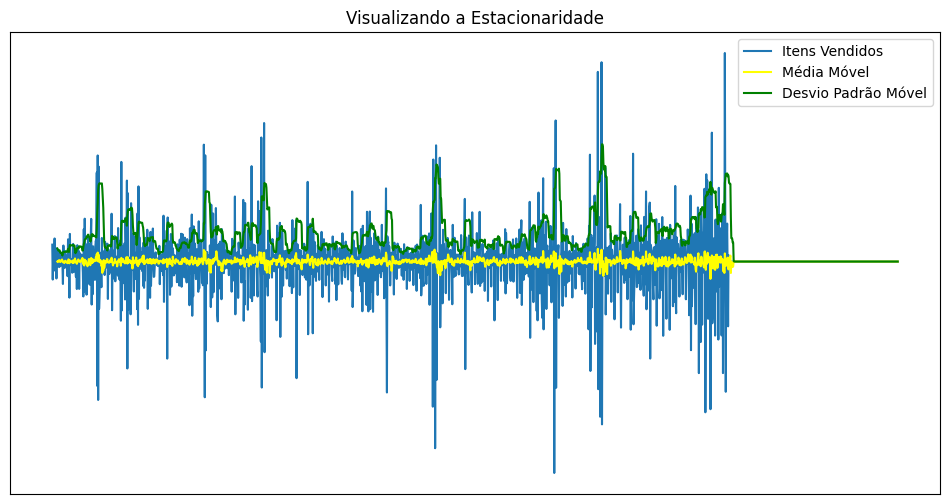

In [139]:
visualiza_estacionaridade(first_diff)

In [140]:
resultado_adft = adfuller(first_diff)
resultado_adft

(-12.922107725046592,
 3.855158140112228e-24,
 25,
 1798,
 {'1%': -3.4339921916016345,
  '5%': -2.8631488249300574,
  '10%': -2.5676264862577503},
 54924.12652134077)

In [141]:
# Resultado
if resultado_adft[1] < 0.05:
    print('O valor-p é menor que 0.05. Podemos rejeitar a H0. A série é estacionária.')
else:
    print('O valor-p é maior que 0.05. Não podemos rejeitar a H0. A série não é estacionária.')

O valor-p é menor que 0.05. Podemos rejeitar a H0. A série é estacionária.


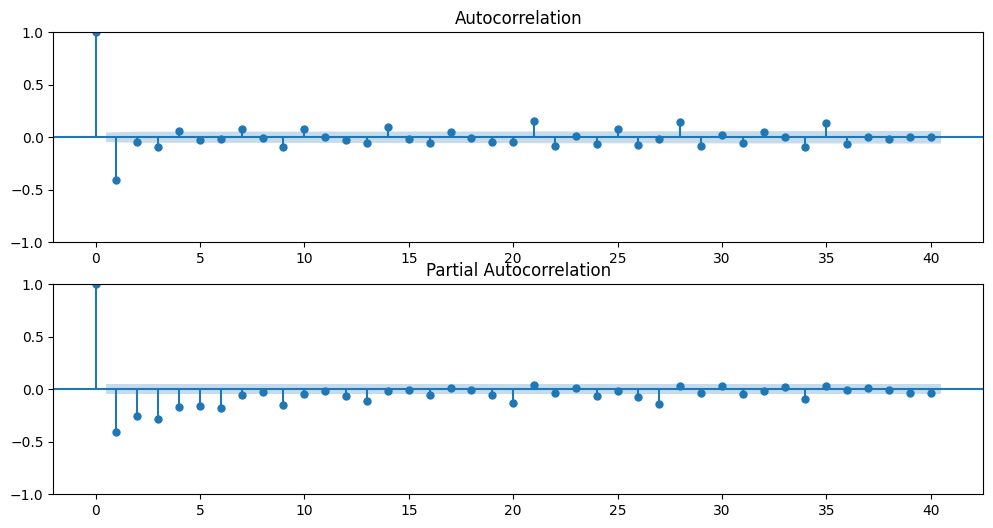

In [142]:
# Plot
fig, axes = plt.subplots(2, figsize = (12,6))
axes[0] = plot_acf(first_diff, ax = axes[0], lags = 40)
axes[1] = plot_pacf(first_diff, ax = axes[1], lags = 40)

In [143]:
# Data limite
cutoff_date = '2022-01-01'
# Prepara datasets de treino e teste
amostra_treino = first_diff.loc[first_diff.index < cutoff_date]
amostra_teste = first_diff.loc[(first_diff.index >= cutoff_date) & (first_diff.index < '2023-01-01')]

In [144]:
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [145]:
modelo_sarimax_v1 = SARIMAX(amostra_treino, trend = 'n', order = (1,1,1), seasonal_order=(1,1,1,30))

In [146]:
# Treinamento do modelo
modelo_v1 = modelo_sarimax_v1.fit(disp = True)

In [147]:
previsoes = modelo_v1.predict(start = cutoff_date, end = '2022-12-31', dynamic = False)

In [148]:
# Aplica a diferenciação em teste
first_diff_teste = first_diff
first_diff_teste.index = pd.to_datetime(first_diff_teste.index)

Text(0.5, 1.0, 'Previsões do Modelo SARIMAX')

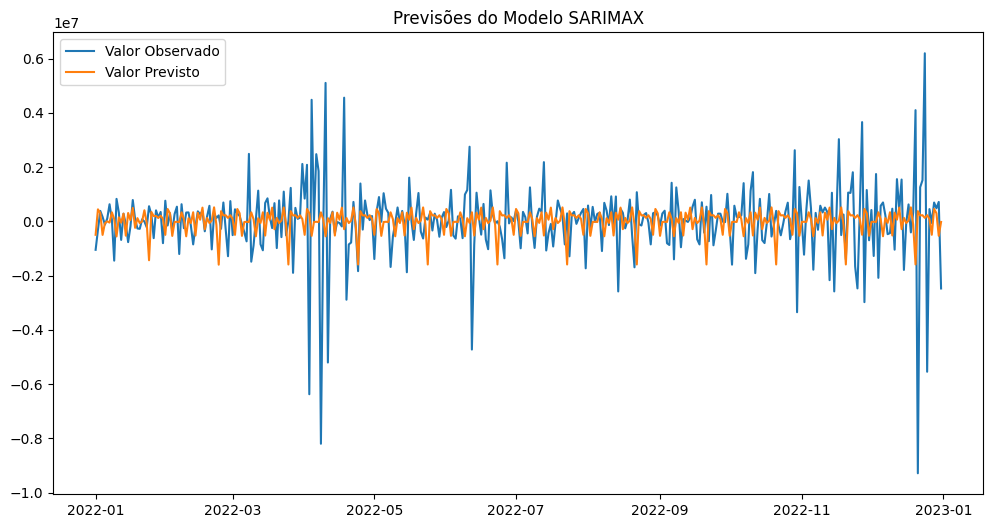

In [149]:
# Plot comparando previsões do modelo para 3 meses, com os dados de teste
fig = plt.figure(figsize = (12,6))
sales = plt.plot(first_diff_teste[(first_diff_teste.index >= '2022-01-01') & (first_diff_teste.index <= '2022-12-31')], label = 'Valor Observado')
forecast = plt.plot(previsoes, label = 'Valor Previsto')
plt.legend(loc = 'best')
plt.title("Previsões do Modelo SARIMAX")

In [150]:
# Erro do modelo - MAE
print('SARIMAX MAE = ', mean_absolute_error(previsoes, amostra_teste))

SARIMAX MAE =  917416.8826773126


In [151]:
# Erro do modelo - MSE
print('SARIMAX MSE = ', mean_squared_error(previsoes, amostra_teste))

SARIMAX MSE =  2273428509962.283


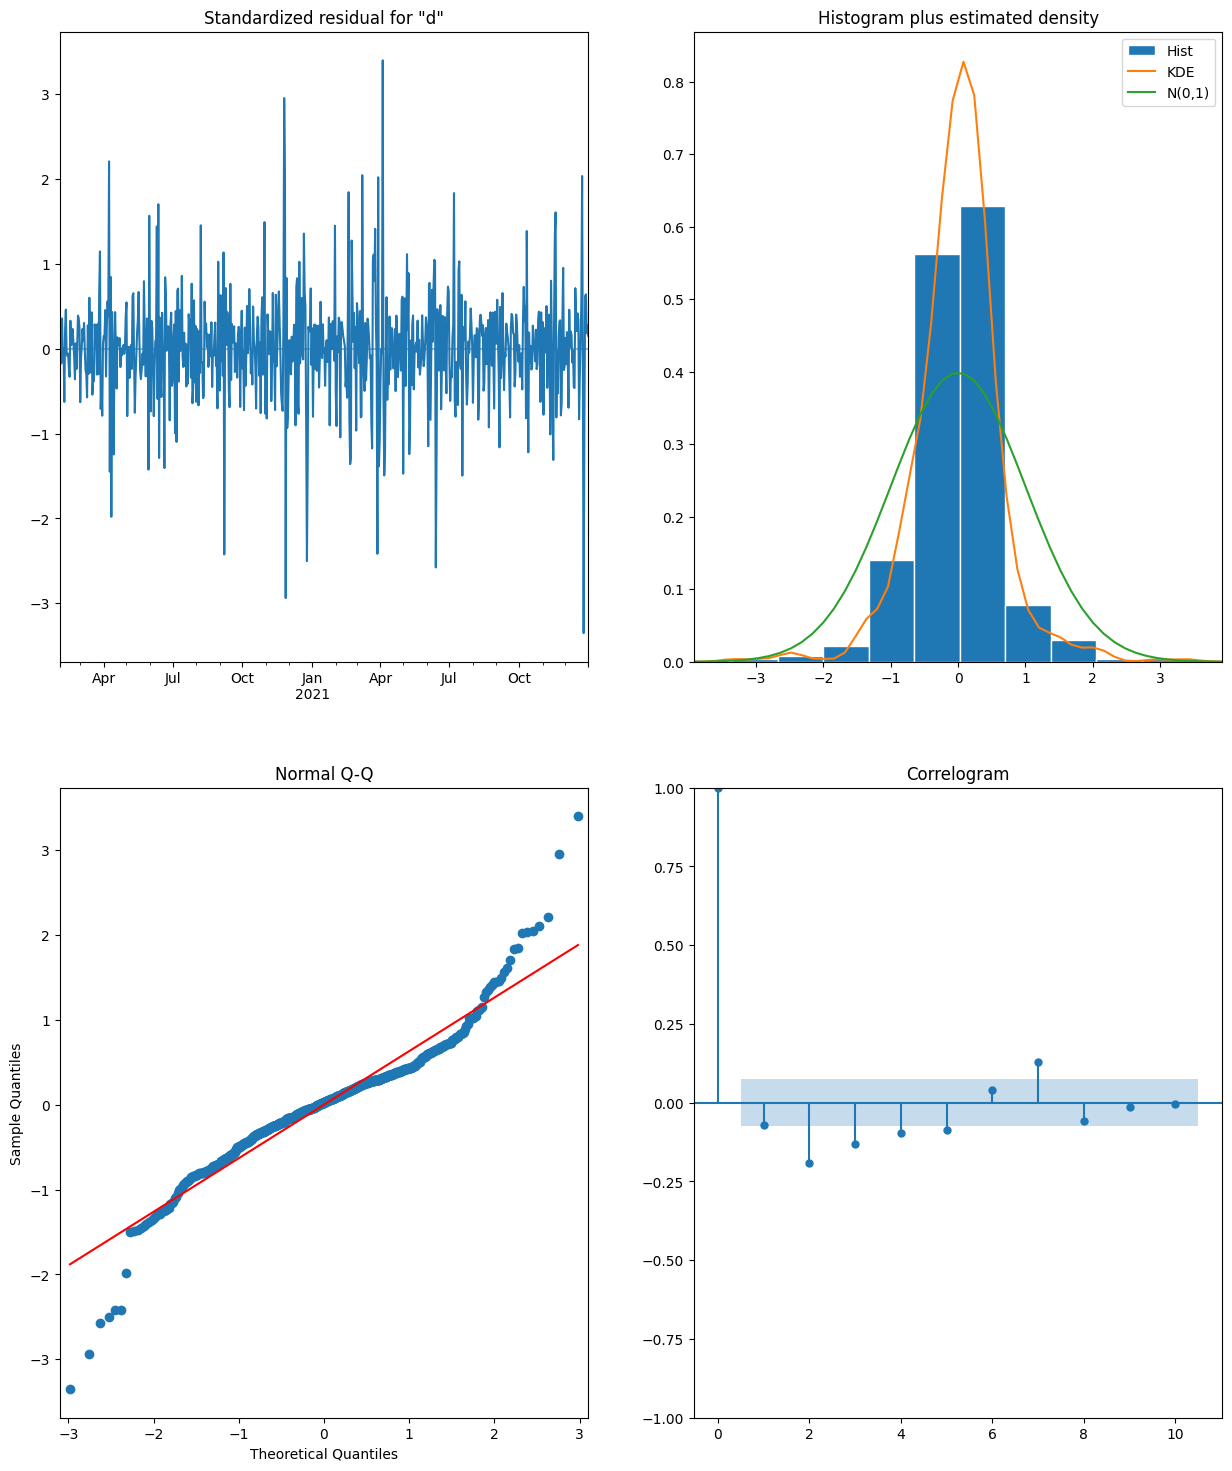

In [152]:
modelo_v1.plot_diagnostics(figsize = (15,18))
plt.show()

In [153]:
last_day = df_diferenca[df_diferenca.index == '2022-12-31']['diferenca']
last_day

data
2022-12-31   -31866.54
Name: diferenca, dtype: float64

In [154]:
previsoes_2023 = modelo_v1.predict(start = '2023-01-01', end = '2023-10-11', dynamic = False)

Text(0.5, 1.0, 'Previsões do Modelo SARIMAX')

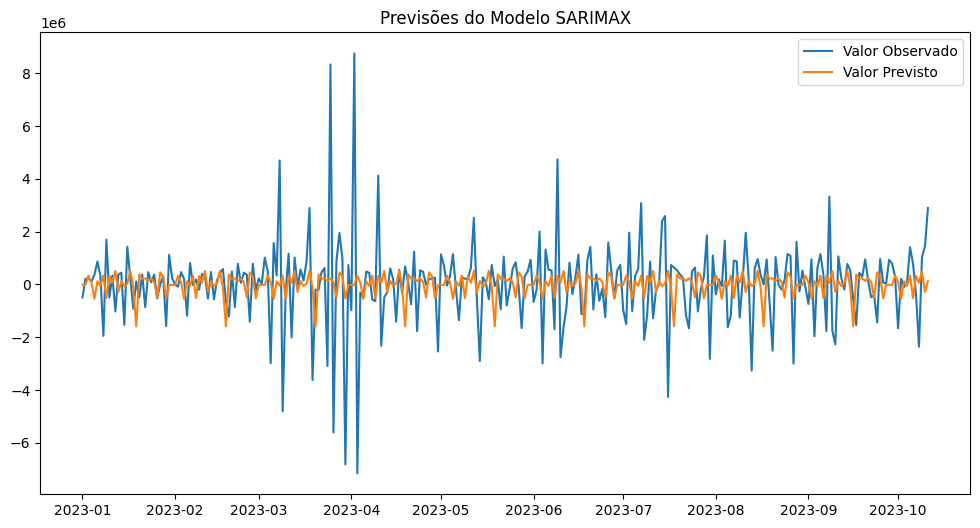

In [155]:
# Plot comparando previsões do modelo para 3 meses, com os dados de teste
fig = plt.figure(figsize = (12,6))
sales = plt.plot(first_diff_teste[(first_diff_teste.index >= '2023-01-01') & (first_diff_teste.index <= '2023-10-11')], label = 'Valor Observado')
forecast = plt.plot(previsoes_2023, label = 'Valor Previsto')
plt.legend(loc = 'best')
plt.title("Previsões do Modelo SARIMAX")

In [156]:
# name the index from previsoes_2023
previsoes_2023.index.name = 'data'
previsoes_2023

data
2023-01-01    -12164.134182
2023-01-02    -21022.731969
2023-01-03    336190.107394
2023-01-04     80935.195929
2023-01-05   -547444.487408
                  ...      
2023-10-07    324608.628360
2023-10-08     65854.817045
2023-10-09    511850.241281
2023-10-10   -283429.800313
2023-10-11    131779.824046
Freq: D, Name: predicted_mean, Length: 284, dtype: float64

In [157]:
previsao_retornada = pd.DataFrame(index=previsoes_2023.index, columns=['previsao_escala_original'])
previsao_retornada['previsao_escala_original'] = previsoes_2023.values
previsao_retornada

,previsao_escala_original
data,
2023-01-01,-12164.134182
2023-01-02,-21022.731969
2023-01-03,336190.107394
2023-01-04,80935.195929
2023-01-05,-547444.487408
...,...
2023-10-07,324608.628360
2023-10-08,65854.817045
2023-10-09,511850.241281


In [158]:
previsoes_2023.index.name = 'data'
previsao_retornada = pd.DataFrame(index=previsoes_2023.index, columns=['previsao_escala_original'])
previsao_retornada['previsao_escala_original'] = previsoes_2023.values
# previsao_retornada['previsao_escala_original'] = np.exp(previsao_retornada['previsao_escala_original'])

for i in range(len(previsoes_2023)):
    if i == 0:
        previsao_retornada.iloc[i] = previsoes_2023.iloc[i] + last_day.values[0]
    else:
        previsao_retornada.iloc[i] = previsoes_2023.iloc[i] + previsao_retornada.iloc[i-1]

previsao_retornada.index.name = 'data'

Text(0.5, 1.0, 'Previsões do Modelo SARIMAX')

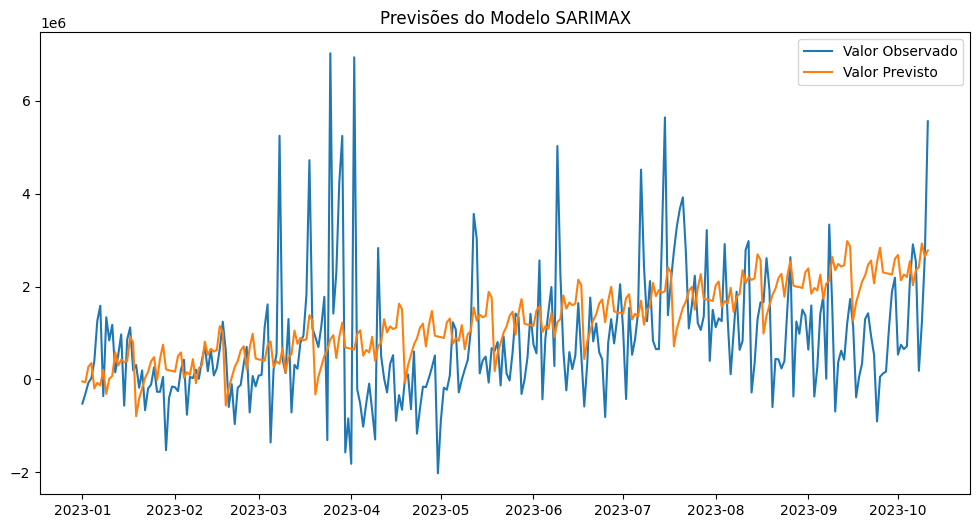

In [159]:
# Plot comparando previsões do modelo para 3 meses, com os dados de teste
fig = plt.figure(figsize = (12,6))
sales = plt.plot(df_diferenca[(df_diferenca.index >= '2023-01-01') & (df_diferenca.index <= '2023-10-11')], label = 'Valor Observado')
forecast = plt.plot(previsao_retornada, label = 'Valor Previsto')
plt.legend(loc = 'best')
plt.title("Previsões do Modelo SARIMAX")

In [160]:
soma_resultado = df_previsao_grandeza.loc[df_previsao_grandeza.index >= '2023-01-01', 'previsao'] + previsao_retornada['previsao_escala_original']
soma_resultado = pd.DataFrame(soma_resultado, columns=['previsao'])
soma_resultado

,previsao
data,
2023-01-01,4.623118e+06
2023-01-02,3.899842e+06
2023-01-03,4.268829e+06
2023-01-04,4.610809e+06
2023-01-05,4.168118e+06
...,...
2024-12-27,NaN
2024-12-28,NaN
2024-12-29,NaN


Text(0.5, 1.0, 'Previsões do Modelo SARIMAX')

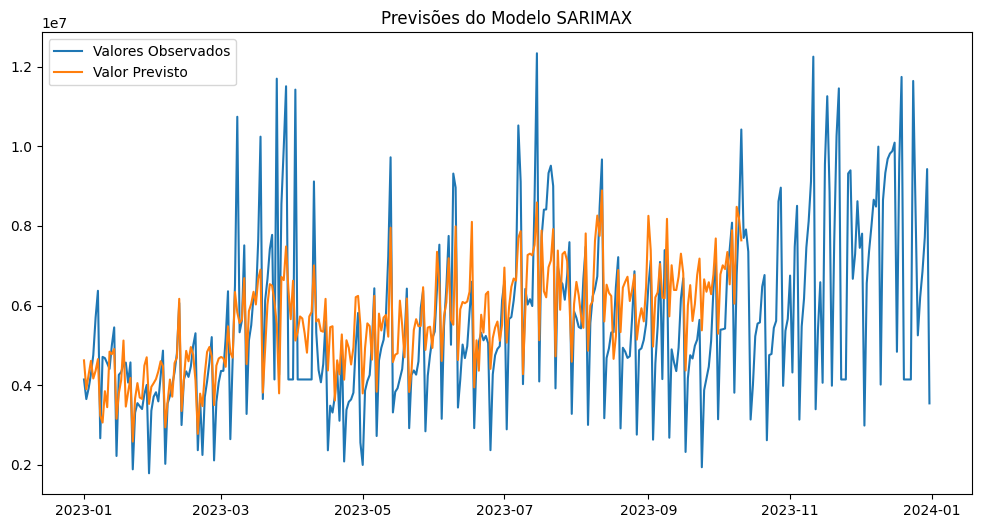

In [161]:
fig = plt.figure(figsize = (12,6))
sales = plt.plot(np.expm1(pd.DataFrame(Y_prev_2023,columns=['gross_sales'])), label = 'Valores Observados')
forecast = plt.plot(soma_resultado, label = 'Valor Previsto')
plt.legend(loc = 'best')
plt.title("Previsões do Modelo SARIMAX")

In [162]:
venda_2023    = np.expm1(Y_prev_2023).sum()
previsao_2023_ajustada = int(soma_resultado.iloc[:-1].sum())

print('Venda de 2023: ', round(venda_2023,2))
print('Previsão de 2023: ', round(previsao_2023_ajustada,2))
print('Erro do modelo: ', abs(round(previsao_2023_ajustada/venda_2023-1,4)))

Venda de 2023:  2034221230.26
Previsão de 2023:  1595138390
Erro do modelo:  0.2158


In [163]:
previsoes_futuro_original = np.expm1(previsoes_val)

df = df_xboost_previsor[cols].reset_index(inplace=False)

df_previsoes_treino = pd.DataFrame({
    'data': df['data'].iloc[:len(previsoes_val)],
    'previsao': previsoes_futuro_original,
    'venda': np.expm1(Y_prev.values),
}) 

df_previsoes_treino = df_previsoes_treino[df_previsoes_treino['data'] >= '2023-01-01']
df_previsoes_treino['previsao_residuos'] = previsao_retornada[:-1].values
df_previsoes_treino['previsao_total'] = soma_resultado[:-1].values

ValueError: All arrays must be of the same length

In [ ]:
project_id = 'project'
dataset_name = 'dataset'
table_name = 'table'

schema = [
    bigquery.SchemaField("data",'DATE', mode='NULLABLE'),                            
    bigquery.SchemaField("previsao",'FLOAT64', mode='NULLABLE'),
    bigquery.SchemaField("venda",'FLOAT64', mode='NULLABLE'),
    bigquery.SchemaField("previsao_residuos",'FLOAT64', mode='NULLABLE'),
    bigquery.SchemaField("previsao_total",'FLOAT64', mode='NULLABLE')
]

# Cria a nova tabela no dataset
table_ref = client.dataset(dataset_name).table(table_name)
try:
    table = client.get_table(table_ref)
    print('A tabela já existe. Os novos dados serão carregados na tabela.')
except:
    print('A tabela não existe. Será criada agora.')
    table = bigquery.Table(table_ref)
    table = client.create_table(table)
    print('A tabela foi criada com sucesso.')

# Carrega os novos dados na tabela existente
job_config = bigquery.LoadJobConfig(write_disposition='WRITE_TRUNCATE', schema=schema)
job = client.load_table_from_dataframe(df_previsoes_treino.drop_duplicates(), table_ref, job_config=job_config)
job.result()
print('Os novos dados foram carregados com sucesso na tabela existente.')

In [ ]:
query_serie = fr"""
WITH previsao AS (
SELECT
     DATE_TRUNC(data,MONTH) AS data_ref
     , ROUND(SUM(previsao),2)                                          AS previsao
     , ROUND(SUM(venda),2)                                             AS venda   
     , ROUND(ABS(SAFE_DIVIDE(SUM(previsao),SUM(venda))-1),4)           AS erro_base
     , ROUND(SUM(previsao_residuos),2)                                 AS previsao_residuos
     , ROUND(SUM(previsao_total),2)                                    AS previsao_total
     , ROUND(ABS(SAFE_DIVIDE(SUM(previsao_total),SUM(venda))-1),4)     AS erro_final
  FROM `table`
 GROUP BY 1
 ORDER BY 1 ASC
)

SELECT *
     , AVG(erro_base) OVER()        media_erro_base
     , STDDEV(erro_base) OVER()     desvio_erro_base
     , AVG(erro_final) OVER()       media_erro_final
     , STDDEV(erro_final) OVER()    desvio_erro_final
     , PERCENTILE_CONT(erro_final, 0.25) OVER() P25
     , PERCENTILE_CONT(erro_final, 0.5)  OVER() P50
     , PERCENTILE_CONT(erro_final, 0.75) OVER() P75
  FROM previsao
"""

resultados_analisados = get_data(query_serie, True)
resultados_analisados.to_csv("resultados_analisados.csv", sep=';', decimal=',', encoding='utf-8-sig', index=False)

### Ideia descartada

In [ ]:
def train_and_evaluate(df_treino, df_validacao, max_depth, learning_rate, min_child_weight, alpha, lambda_, n_estimators):
    df_xboost = venda_companhia.copy()

    metricas_treinadas = []
    modelos_treinados = []
    features_flags = []

    for i in range(50):
        df_xboost, df_xboost_previsor, features_aplicadas = transforma_modelos(df_treino, df_validacao, date_col='order_date', sales_col='gross_sales', lag_list=lag_list, windows_list=windows_list, alpha_list=alpha_list, lags=lags, i=i)
        features_flags.append(features_aplicadas)

        # Separa X e Y
        # x without gross sales
        cols = [col for col in df_xboost.columns if col not in ['order_date', 'id', "gross_sales", "year"]]
        X = df_xboost[cols]
        Y = df_xboost['gross_sales']
        X_treino, X_teste, y_treino, y_teste = train_test_split(X, Y, test_size = 0.2, random_state = 1)
        X_treino, X_val, y_treino, y_val = train_test_split(X_treino, y_treino, test_size = 0.25, random_state = 1)

        # treining model using XGBoost and cross validation
        max_depth=max_depth
        learning_rate=learning_rate
        min_child_weight=min_child_weight
        alpha=alpha
        lambda_=lambda_
        n_estimators=n_estimators

        # Crie o modelo XGBoost com os hiperparâmetros definidos
        modelo_xgb = xgb.XGBRegressor(
            max_depth=max_depth,
            learning_rate=learning_rate,
            n_estimators=n_estimators,
            min_child_weight=min_child_weight,
            alpha=alpha,
            lambda_=lambda_,
        )

        # Treine o modelo
        modelo_xgb.fit(
            X_treino,
            y_treino,
            eval_set=[(X_val, y_val)],
            verbose=True,
            eval_metric='rmse',
            early_stopping_rounds=20
        )

        previsoes_treino = modelo_xgb.predict(X_teste)
        previsoes_val = modelo_xgb.predict(df_xboost_previsor[cols])
        # add date to previsoes_ult_trim_xgb
        df_previsto = df_xboost_previsor.copy()
        df_previsto['previsao'] = np.expm1(previsoes_val)
        df_previsto = np.log1p(df_previsto['previsao'])

        # filter df_previsto with index date from serie Y_prev
        df_previsto = df_previsto[df_previsto.index.isin(Y_prev.index)]
        df_previsto

        mae_treino   = mean_absolute_error(previsoes_treino, y_teste.values)
        mse_treino   = mean_squared_error(previsoes_treino, y_teste.values)
        rmse_treino  =  mean_squared_error(previsoes_treino, y_teste.values, squared=False)
        mape_treino  =  mean_absolute_percentage_error(previsoes_treino, y_teste.values)

        mae_validacao   = mean_absolute_error(df_previsto,Y_prev.values)
        mse_validacao   = mean_squared_error(df_previsto,Y_prev.values)
        rmse_validacao  =  mean_squared_error(df_previsto,Y_prev.values, squared=False)
        mape_validacao  =  mean_absolute_percentage_error(df_previsto,Y_prev.values)


        metricas = [
            {
                'modelo': f'Modelo {i}',
                'mae_treino': mae_treino,
                'mse_treino': mse_treino,
                'rmse_treino': rmse_treino,
                'mape_treino': mape_treino,
                'mae_validacao': mae_validacao,
                'mse_validacao': mse_validacao,
                'rmse_validacao': rmse_validacao,
                'mape_validacao': mape_validacao,
                'diferenca_relativa_mse': abs(mse_treino - mse_validacao) / mse_treino,
            }
        ]

        modelos = {
            'modelo': f'Modelo {i}',
            'modelo_xgb': modelo_xgb
        }
        metricas_treinadas.append(metricas)
        modelos_treinados.append(modelos)
    menor_mse = float('inf')  # Inicialize com infinito
    indice_menor_mse = -1  # Inicialize com um valor inválido

    for i, metrica in enumerate(metricas_treinadas):
        mse_validacao_atual = metrica[0]['mse_validacao']  # Acessa o valor de 'mse_validacao' no dicionário atual
        if mse_validacao_atual < menor_mse:
            menor_mse = mse_validacao_atual
            indice_menor_mse = i

    melhor_modelo = modelos_treinados[indice_menor_mse]
    metrica_final = metricas_treinadas[indice_menor_mse]
    features_final = features_flags[indice_menor_mse]
    
    return modelos_treinados, metricas_treinadas, features_aplicadas, melhor_modelo, metrica_final, features_final